构建模糊控制器的步骤：
- 确定模糊控制器**输入**与**输出**
- 设计模糊控制器**控制规则**
- 确立**模糊化**和**非模糊化**的方法
- 选择模糊控制器的输入变量和输出变量的**论域U**

# 实例
设计一个自动灌溉系统，根据**土壤湿度**情况决定**灌溉时间T**

## 1. 输入输出论域

**Inout**:
- `e`：土壤湿度偏差
- `de`：土壤湿度偏差变化率

**Output**：
- `u`：灌溉时间t

**物理论域U**
- `e`: [-10%,10%].在初花期，最佳土壤湿度为23.31%，则实际湿度变化范围为[13.31%,33,31%]
- `de`: [-15%,15%]
- `u`; [0,40 min]

## 2.输入输出模糊语言变量
    数量一般根据实际情况来定，一般而言，将模糊论域划分的越细，能覆盖的情况越全面，控制效果越好，但是相应规则越多，负责度高。一般输入输出牧户语言变量数量为5或者7个。

本例设计**模糊语言变量**如下：
- `e`:NB,NM,NS,ZO,PS,PM,PB
- `de`:NB,NM,NS,ZO,PS,PM,PB
- `u`:ZO,PS,PS+,PM,PM+,PB,PB+

为了方便后面模糊变量的赋值及模糊规则响应表的制作，输入输出变量的 **模糊论域N** 如下：
- `e`:[-6,6]
- `de`:[-6,6]
- `u`:[0,6]

## 3.控制器参数
> 量化因子：从物理论域U映射到模糊论域N的变换系数

> 比例因子：从N模糊论域映射到物理论域U的变化系数

- 量化因子: `Ke=6/10=0.6`,`kde=6/15=0.4`
- 比例因子: `Ku=40*60/6=400`

## 4.隶属度函数
  隶属度函数定量地描述了输入变量精确值到模糊集合的映射关系，选择合适的隶属度函数是进行模糊推理的前提。当输入模糊子集均勻的分布在模糊论域上时，模糊控制器的结构最佳。
  
  本例采用`三角形隶属度函数`，使其**均匀分布**在整个论域。


In [76]:
class MembershipFunction:
    def __init__(self,name,variable,Nmin,Nmax):
        self.variable = variable
        self.name = name
        self.Nmax = Nmax
        self.Nmin = Nmin
        self.picxlist = []
        self.picylist = []
        self.piccolor = ["red","orange","yellow","g","b","blueviolet","indigo"]
    def pic(self):
        tepxlist =[]
        Dist = (self.Nmax - self.Nmin) / (len(self.variable) - 1)
        for i in range(len(self.variable)):
            a = self.Nmin + i*Dist - Dist
            b = self.Nmin + i*Dist
            c = self.Nmin + i*Dist + Dist
            self.picxlist.append(a)
            self.picxlist.append(b)
            self.picxlist.append(c)
        for i in range(len(self.variable)):
            tepxlist = self.picxlist[i*3:(i*3+3)]
            plt.plot(tepxlist,[0,1,0],label=self.variable[i],color=self.piccolor[i])
        plt.xlim(xmax=self.Nmax,xmin=self.Nmin)
        plt.ylim(ymax=1,ymin=0)
        plt.xlabel('variable:'+self.name)
        plt.title("membership function of "+self.name)
        plt.legend(loc=1)
        plt.show()      
        

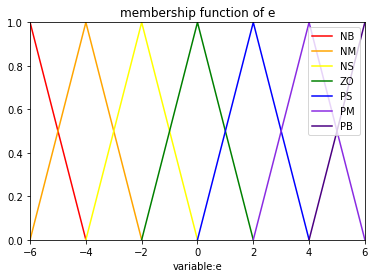

In [77]:
from matplotlib import pyplot as plt
%matplotlib inline
E_MF = MembershipFunction(name="e",variable=["NB","NM","NS","ZO","PS","PM","PB"],Nmin=-6,Nmax=6)
E_MF.pic()

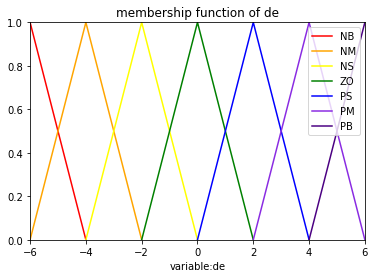

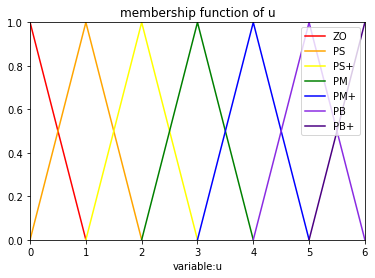

In [78]:
# 同理有de和u的隶属度函数
DE_MF = MembershipFunction(name="de",variable=["NB","NM","NS","ZO","PS","PM","PB"],Nmin=-6,Nmax=6)
DE_MF.pic()
U = MembershipFunction(name="u",variable=["ZO","PS","PS+","PM","PM+","PB","PB+"],Nmin=0,Nmax=6)
U.pic()

## 5.模糊规则制定
模糊规则的确定通常依赖于**实践经验**或者**大量数据**。

本例借鉴模糊PID控制规则，制作模糊逻辑规则表.

In [80]:
import pandas as pd

In [107]:
FuzzyLogic = [["PB+","PB","PM+","PM","ZO","ZO","ZO"],["PB","PM+","PM","PS+","ZO","ZO","ZO"],["PM+","PM","PS+","PS","ZO","ZO","ZO"],["PM","PS+","PS","ZO","ZO","ZO","ZO"],["PS+","PS","ZO","ZO","ZO","ZO","ZO"],["PS","PS","ZO","ZO","ZO","ZO","ZO"],["PS","ZO","ZO","ZO","ZO","ZO","ZO"]]
de_universal=["NB","NM","NS","ZO","PS","PM","PB"]
e_universal=["NB","NM","NS","ZO","PS","PM","PB"]
FuzzyRule_pd = pd.DataFrame(FuzzyLogic, 
                            index=pd.MultiIndex.from_product([["de"],de_universal]),
                            columns=pd.MultiIndex.from_product([["e"],e_universal]))
FuzzyRule_pd

e                           
        NB   NM   NS   ZO  PS  PM  PB
de NB  PB+   PB  PM+   PM  ZO  ZO  ZO
   NM   PB  PM+   PM  PS+  ZO  ZO  ZO
   NS  PM+   PM  PS+   PS  ZO  ZO  ZO
   ZO   PM  PS+   PS   ZO  ZO  ZO  ZO
   PS  PS+   PS   ZO   ZO  ZO  ZO  ZO
   PM   PS   PS   ZO   ZO  ZO  ZO  ZO
   PB   PS   ZO   ZO   ZO  ZO  ZO  ZO

## 6.模糊规则响应表
模糊控制器首先把精确的输入量模糊化为输入变量的论域中，再根据结果查询模糊控制响应表求出结果，对执行机构进行控制。

In [ ]:
IniList = []
